In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from itertools import product

import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 
import plot

import data_collections

/glade/work/mclong/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


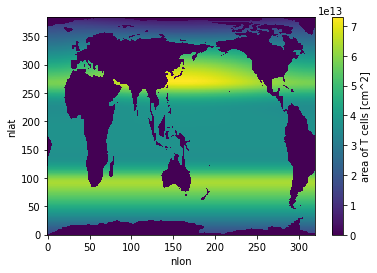

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
masked_area = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.).expand_dims('region')
masked_area.plot()

In [4]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.15:42004 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
experiments = [
    'historical',
    'SSP1-2.6',
    'SSP2-4.5',
    'SSP3-7.0',
    'SSP5-8.5',
]

time_slice = {
    'historical': slice("1990-01-15", "2015-01-15"),
    'SSP1-2.6': slice("2086-01-15", "2101-01-15"),
    'SSP2-4.5': slice("2086-01-15", "2101-01-15"),
    'SSP3-7.0': slice("2086-01-15", "2101-01-15"),
    'SSP5-8.5': slice("2086-01-15", "2101-01-15"),
}

varlist = [
    'photoC_TOT_zint_100m',
    'photoC_diat_zint_100m',
    'POC_FLUX_100m', 
]

query = dict(
    experiment=experiments,
    stream='pop.h',
)

ts_int = data_collections.global_integral_timeseries_ann(query)

epoch_mean = data_collections.epoch_mean(query)
epoch_mean

{ 'esm_collection': 'data/campaign-cesm2-cmip6-timeseries.json',
  'name': 'epoch_mean',
  'operator_kwargs': [ { },
                       { }],
  'operators': [ 'center_time',
                 '_mean_time_for_experiment'],
  'preprocess': None}

In [6]:
nmolcm2s_to_molm2yr = 1e-9 * 1e4 * 86400 * 365.

dsets_epoch = epoch_mean.to_dataset_dict(varlist, clobber=False)

for key, ds in dsets_epoch.items():
    for v in varlist:
        if ds[v].attrs['units'] == 'mmol/m^3 cm/s':
            ds[v] = ds[v] * nmolcm2s_to_molm2yr
            ds[v].attrs['units'] = 'mol m$^{-2}$ yr$^{-1}$'        
    ds['NPP_diat_frac_100m'] = ds.photoC_diat_zint_100m / ds.photoC_TOT_zint_100m
    ds['ep_ratio_100m'] = ds.POC_FLUX_100m / ds.photoC_TOT_zint_100m
    ds = ds.compute()
    
dsets_epoch


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


{'ocn.SSP1-2.6.pop.h': <xarray.Dataset>
 Dimensions:                 (lat_aux_grid: 395, member_id: 3, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
 Coordinates:
     ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
   * member_id               (member_id) int64 4 10 11
   * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
   * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
   * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
   * lat_aux_grid            (lat_aux_grid) flo

In [7]:
dsets_ts = ts_int.to_dataset_dict(varlist, clobber=False)

for key, ds in dsets_ts.items():
    ds['NPP_diat_frac_100m'] = ds.photoC_diat_zint_100m / ds.photoC_TOT_zint_100m
    ds['ep_ratio_100m'] = ds.POC_FLUX_100m / ds.photoC_TOT_zint_100m
    ds = ds.compute()
    
dsets_ts


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'


{'ocn.SSP1-2.6.pop.h': <xarray.Dataset>
 Dimensions:                 (lat_aux_grid: 395, member_id: 3, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 86, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
 Coordinates:
   * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
   * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
   * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
   * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
   * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
   * member_id               (member_id) int64 4 10 11
   * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
   * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
   * time                    (time) int64 2015 2016 2017 2018 ... 2098 2099 2100
 Dimensions without coordinates: moc_

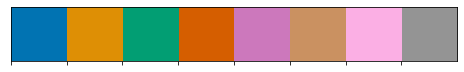

In [8]:
import seaborn as sns

current_palette = sns.color_palette('colorblind', 8)
sns.palplot(current_palette)

exp_colors = {
    'PI': current_palette.as_hex()[-1],
    'historical': 'k',
    'SSP1-2.6': current_palette.as_hex()[0],
    'SSP2-4.5': current_palette.as_hex()[1],
    'SSP3-7.0': current_palette.as_hex()[2],
    'SSP5-8.5': current_palette.as_hex()[3],
}

In [9]:
variable_labels = dict(
    time='Year',
    FG_CO2='Air-sea CO$_2$ flux [Pg C yr$^{-1}$]',
    photoC_TOT_zint_100m='NPP (z > -100m) [Pg C yr$^{-1}$]',
    photoC_TOT_zint='NPP [Pg C yr$^{-1}$]',
    POC_FLUX_100m='POC flux (100 m) [Pg C yr$^{-1}$]',
    ATM_CO2='Atmospheric CO$_2$ [ppm]',
    SST='Temperature [°C]',
    ep_ratio_100m='ep ratio',
    NPP_diat_frac_100m='Diatom fraction of NPP',
)
varlist_all = varlist + ['NPP_diat_frac_100m', 'ep_ratio_100m']

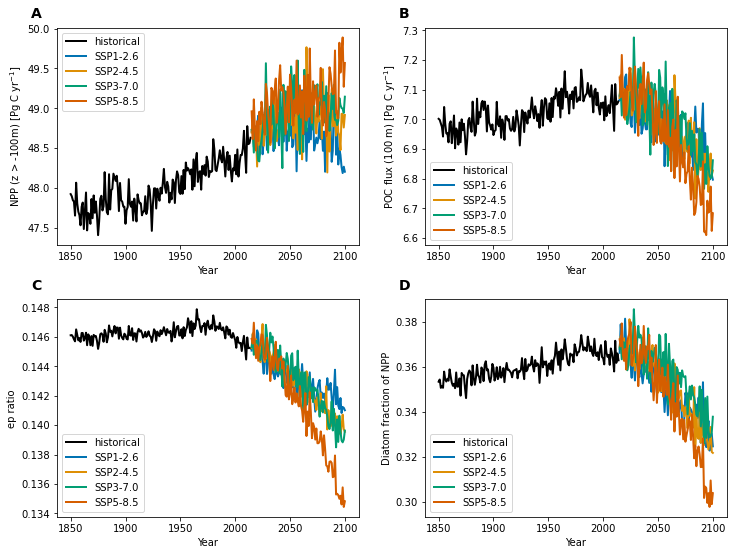

In [10]:
nrow = 2
ncol = 2
#fig, axs = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), constrained_layout=False)

fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(
    nrows=2, ncols=2, 
    hspace=0.25,
    wspace=0.22,
)
axs = np.empty((2, 2)).astype(object)
for i, j in product(range(2), range(2)):
    axs[i, j] = plt.subplot(gs[i, j])


X = [['time', 'time'], ['time', 'time'],]
Y = [['photoC_TOT_zint_100m', 'POC_FLUX_100m'], ['ep_ratio_100m', 'NPP_diat_frac_100m'],]

for i, j in product(range(2), range(2)):
    ax = axs[i, j]
    x = X[i][j]
    y = Y[i][j]
    for exp in experiments:
        if exp == 'piControl':
            continue
        ds = dsets_ts[f'ocn.{exp}.pop.h']
        #for member_id in ds.member_id.values:
        #    ax.plot(ds.time, ds[v].sel(member_id=member_id), '-', alpha=0.25, linewidth=1, color=exp_colors[exp])
        ax.plot(ds[x], ds[y].mean('member_id'), '-', linewidth=2, color=exp_colors[exp], label=exp)

    ax.set_ylabel(variable_labels[y])    
    ax.legend()
    ax.set_xlabel(variable_labels[x])
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=-0.03, yoff=0.015)   

utils.savefig(f'global-timeseries-bio-pump')

In [11]:
ds_delta = (dsets_epoch['ocn.SSP5-8.5.pop.h'][varlist_all] - dsets_epoch['ocn.historical.pop.h'][varlist_all]).mean('member_id')
ds_delta

<xarray.Dataset>
Dimensions:                (nlat: 384, nlon: 320)
Coordinates:
    ULONG                  (nlat, nlon) float64 321.1 322.3 ... 319.6 320.0
    ULAT                   (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
    TLONG                  (nlat, nlon) float64 320.6 321.7 ... 319.4 319.8
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    photoC_TOT_zint_100m   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    photoC_diat_zint_100m  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    POC_FLUX_100m          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    NPP_diat_frac_100m     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ep_ratio_100m          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [12]:
dsp = utils.pop_add_cyclic(ds_delta)
dsp

<xarray.Dataset>
Dimensions:                (nlat: 384, nlon: 321)
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT                   (nlat, nlon) float64 -79.22 -79.22 ... 80.31 80.31
    TLONG                  (nlat, nlon) float64 -220.6 -219.4 ... -39.57 -39.86
    photoC_TOT_zint_100m   (nlat, nlon) float64 dask.array<chunksize=(384, 161), meta=np.ndarray>
    photoC_diat_zint_100m  (nlat, nlon) float64 dask.array<chunksize=(384, 161), meta=np.ndarray>
    POC_FLUX_100m          (nlat, nlon) float64 dask.array<chunksize=(384, 161), meta=np.ndarray>
    NPP_diat_frac_100m     (nlat, nlon) float64 dask.array<chunksize=(384, 161), meta=np.ndarray>
    ep_ratio_100m          (nlat, nlon) float64 dask.array<chunksize=(384, 161), meta=np.ndarray>

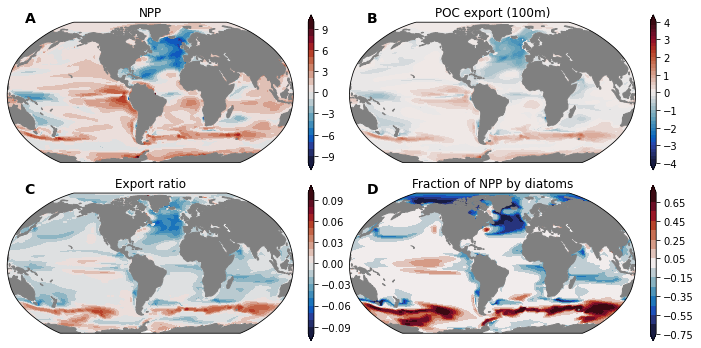

In [13]:
fig = plt.figure(figsize=(12, 6))
prj = ccrs.Robinson(central_longitude=305.0)

titles = dict(
    photoC_TOT_zint_100m='NPP', 
    POC_FLUX_100m='POC export (100m)', 
    ep_ratio_100m='Export ratio',
    NPP_diat_frac_100m='Fraction of NPP by diatoms',
)


nrow, ncol = 2, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol*3, 
    width_ratios=(1, 0.02, 0.02)*ncol,
    wspace=0.15, 
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j*3], projection=prj)
    caxs[i, j] = plt.subplot(gs[i, j*3+1])

    
levels = dict(
    photoC_TOT_zint_100m=np.arange(-10, 11, 1),
    POC_FLUX_100m=np.arange(-4, 4.2, 0.2),
    ep_ratio_100m=np.arange(-10, 11, 1)/100.,
    NPP_diat_frac_100m=np.arange(-0.75, 0.76, 0.1)
)

cmap_field = cmocean.cm.balance

for n, field in enumerate(['photoC_TOT_zint_100m', 'POC_FLUX_100m', 'ep_ratio_100m', 'NPP_diat_frac_100m']):
    
    i, j = np.unravel_index(n, axs.shape)
    
    ax = axs[i, j]
   
    cf = ax.contourf(
        dsp.TLONG, dsp.TLAT, dsp[field],
        levels=levels[field],
        extend='both',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )  
                             
    ax.set_title(titles[field]) #dsp[field].attrs['title_str'])

    
    cb = plt.colorbar(cf, cax=caxs[i, j])
    if 'units' in dsp[field].attrs:
        cb.ax.set_title(dsp[field].attrs['units'])
    
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('bio-pump-change-2100-SSP5-8_5')

In [14]:
del client
del cluster